In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import os
from scipy import signal
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import SchemDraw as schemdraw
import SchemDraw.elements as elm

# The spice and kicad modules are located above us
import sys
sys.path.append('../../lib/python')

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

![module](https://img.shields.io/badge/module-vca-yellow)
![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *pe|gel*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
## *about*

pegel is a voltage controlled amplifier (vca). there are various designs to implement a vca. rod elliott (ESP) has an article on vca techniques [[1][1]]. diy synthesizer modules are usualy designed with an integrated vca chip [[2][2]]  or with a differential amplifier [[3][3]]. the integrated vca chips are either obsolete or rather expensive. the differential amplifier can be built with transistors only. the design has some downsides. even in the simulation the result is not symetryc and has a dc offset from the control voltage. this needs a lot of trimming to get an accurate result. but the biggest downside is, that this design can not do proper amplitude modulation (am). when the carrier signal goes below zero the base signal is completely muted. 

In [2]:
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath(
    'diffpair', 'diffpair.cir')
parser = SpiceParser(path=str(kicad_netlist_path))
diffpair = parser.build_circuit(ground=5)
diffpair.include(spice_library['BC547B'])
#print(str(diffpair))


2020-08-16 16:40:12,266 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Error: bad type for debug var
2020-08-16 16:40:12,267 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: ngspice compiled without debug messages


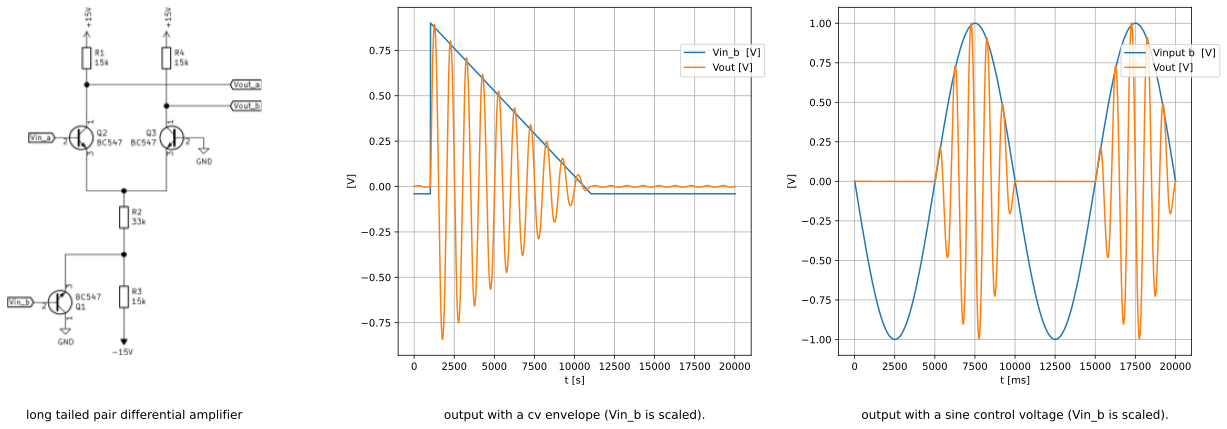

In [3]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#plot the image
directory_path = Path(os.path.abspath('')).resolve()
img_diffpair_path = directory_path.joinpath(
    'diffpair', 'diffpair.png')
img_diffpair = mpimg.imread(str(img_diffpair_path))
im = ax0.imshow(img_diffpair)
ax0.axis('off')
ax0.set_title('long tailed pair differential amplifier', y=-0.2)
        
#plot the envelope
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath(
    'diffpair', 'diffpair.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

diffpair_envelope = parser.build_circuit(ground=5)

diffpair_envelope.include(spice_library['BC547B'])

diffpair_envelope.V('3', 'Vin_a', diffpair.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
diffpair_envelope.V('4', 'Vin_b', diffpair.gnd, 'DC 0V AC 0V PULSE(200m -4.5 1m 1u 10m 1u)')

simulator = diffpair_envelope.simulator(temperature=25, nominal_temperature=25)
analysis_envelope = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

ax1.plot(analysis_envelope['Vin_b'] * 0.2 * -1)  # envelope input (scaled)
ax1.plot(analysis_envelope['Vout_b'] - analysis_envelope['Vout_a'])  # differential output
ax1.legend(('Vin_b  [V]', 'Vout [V]'), loc=(.8, .8))
ax1.grid()
ax1.set_xlabel('t [s]')
ax1.set_ylabel('[V]')
ax1.set_title('output with a cv envelope (Vin_b is scaled).', y=-0.2)

# Function x**(1/2)
def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2

#plot the amplitude modulation
diffpair_am = parser.build_circuit(ground=5)

diffpair_am.include(spice_library['BC547B'])

diffpair_am.V('3', 'Vin_a', diffpair_am.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
diffpair_am.V('4', 'Vin_b', diffpair_am.gnd, 'DC 0V AC 0V SIN(0 5 100)')

simulator = diffpair_am.simulator(temperature=25, nominal_temperature=25)
analysis_am = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

ax2.plot(analysis_am['Vin_b'] * 0.2 * -1)  # differential output
ax2.plot(analysis_am['Vout_b'] - analysis_am['Vout_a'])  # differential output
ax2.legend(('Vinput b  [V]', 'Vout [V]'), loc=(.8, .8))
ax2.grid()
ax2.set_xlabel('t [ms]')
ax2.set_ylabel('[V]')
ax2.set_title('output with a sine control voltage (Vin_b is scaled).', y=-0.2)
#ax2.set_yscale('function', functions=(forward,inverse))
plt.tight_layout()
plt.show()


more promising is it to use a four quadrant multiplier, also known as gilbert cell. the gilbert cell is designed around two differential amplifiers. the carrier signal switches between those. the result is a multiplication of the input voltages. the gilbert cell is mostly used for amplitude modulation in radio transmission. if you look at the integratd circuits like the 633 it can modulate signals up in the gigahertz range. the gilbert cell is not described in all details here, there is a good introduction from w2aew [[4][4]].




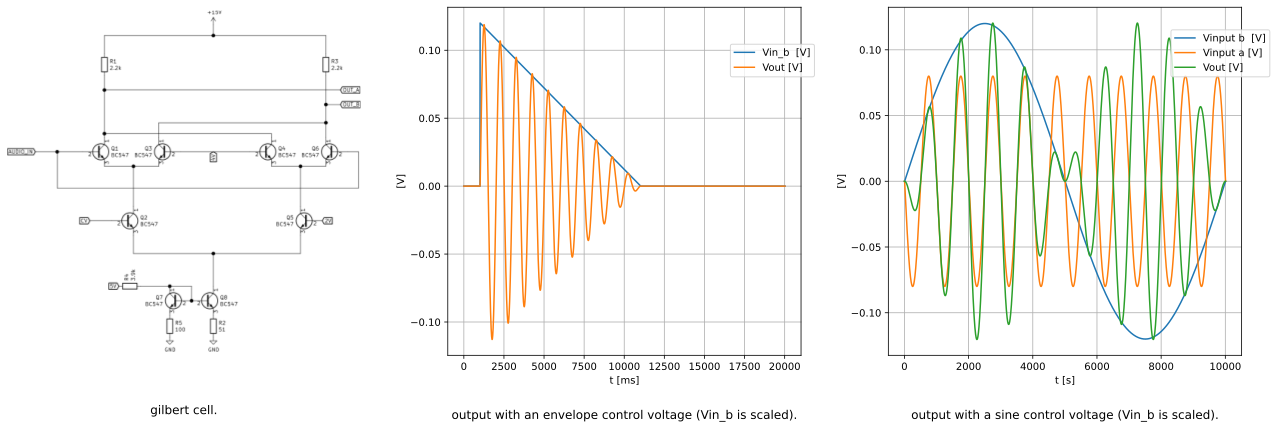

In [4]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#plot the image
directory_path = Path(os.path.abspath('')).resolve()
img_diffpair_path = directory_path.joinpath(
    'gilbert_cell', 'gilbert_cell.png')
img_diffpair = mpimg.imread(str(img_diffpair_path))
im = ax0.imshow(img_diffpair)
ax0.axis('off')
ax0.set_title('gilbert cell.', y=-0.2)

#plot the envelope
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath(
    'gilbert_cell', 'gilbert_cell.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

gilbert_cell_envelope = parser.build_circuit(ground=5)
gilbert_cell_envelope.include(spice_library['BC547B'])

gilbert_cell_envelope.V('3', 'AUDIO_IN', gilbert_cell_envelope.gnd, 'DC 0V AC 0V SIN(4 10m 1k)')
gilbert_cell_envelope.V('4', 'CV', gilbert_cell_envelope.gnd, 'DC 0V AC 0V PULSE(2 1990m 1m 1u 10m 1u)')

simulator = gilbert_cell_envelope.simulator(temperature=25, nominal_temperature=25)
analysis_gilbert_cell_envelope = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

ax1.plot((analysis_gilbert_cell_envelope['CV'] - 2.0@u_V) * -12)  # differential output
ax1.plot(analysis_gilbert_cell_envelope['OUT_A'] - analysis_gilbert_cell_envelope['OUT_B'])  # differential output
ax1.legend(('Vin_b  [V]', 'Vout [V]'), loc=(.8, .8))
ax1.grid()
ax1.set_xlabel('t [ms]')
ax1.set_ylabel('[V]')
ax1.set_title('output with an envelope control voltage (Vin_b is scaled).', y=-0.2)

#plot the amplitude modulation
gilbert_am = parser.build_circuit(ground=5)
gilbert_am.include(spice_library['BC547B'])

gilbert_am.V('3', 'AUDIO_IN', gilbert_am.gnd, 'DC 0V AC 0V SIN(4 10m 1k)')
gilbert_am.V('4', 'CV', gilbert_am.gnd, 'DC 0V AC 0V SIN(2 10m 100)')

simulator = gilbert_am.simulator(temperature=25, nominal_temperature=25)
analysis_gilbert_am = simulator.transient(step_time=1@u_us, end_time=10@u_ms)

ax2.plot((analysis_gilbert_am['CV'] - 2.0@u_V) * 12)  # differential output
ax2.plot((analysis_gilbert_am['AUDIO_IN'] - 4.0@u_V) * -8)  # differential output
ax2.plot(analysis_gilbert_am['OUT_A'] - analysis_gilbert_am['OUT_B'])  # differential output
ax2.legend(('Vinput b  [V]', 'Vinput a [V]', 'Vout [V]'), loc=(.8, .8))
ax2.grid()
ax2.set_xlabel('t [s]')
ax2.set_ylabel('[V]')
ax2.set_title('output with a sine control voltage (Vin_b is scaled).', y=-0.2)

plt.tight_layout()
plt.show()


this is not real amplitude modulation. when the signal is negative the phase of the output is inverted. this can be adjusted by the bias voltage of the control voltage. the control voltage has to be positive at all time. 


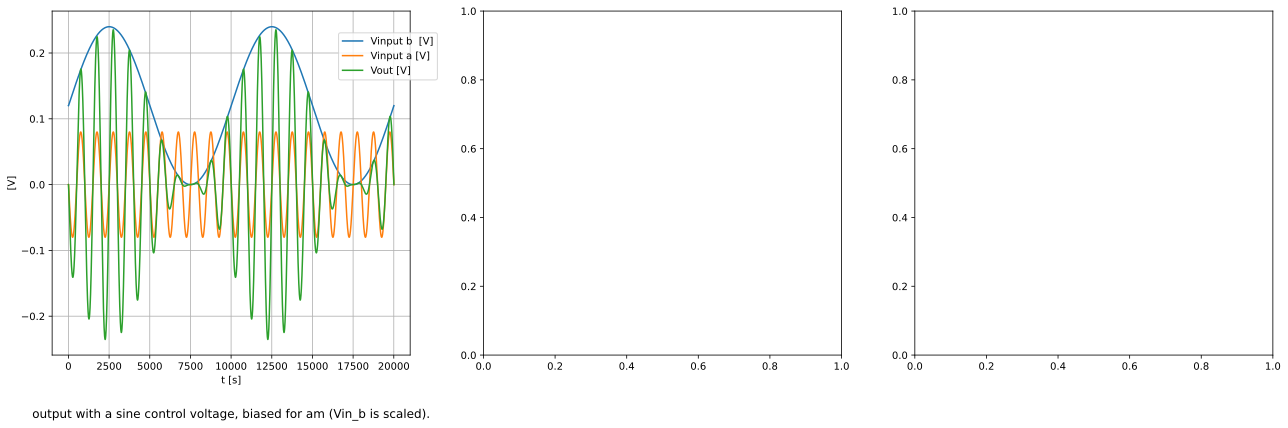

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#plot the amplitude modulation
gilbert_real_am = parser.build_circuit(ground=5)
gilbert_real_am.include(spice_library['BC547B'])

gilbert_real_am.V('3', 'AUDIO_IN', gilbert_real_am.gnd, 'DC 0V AC 0V SIN(4 10m 1k)')
gilbert_real_am.V('4', 'CV', gilbert_real_am.gnd, 'DC 0V AC 0V SIN(2.01 10m 100)')

simulator = gilbert_real_am.simulator(temperature=25, nominal_temperature=25)
analysis_gilbert_real_am = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

ax0.plot((analysis_gilbert_real_am['CV'] - 2.0@u_V) * 12)  # differential output
ax0.plot((analysis_gilbert_real_am['AUDIO_IN'] - 4.0@u_V) * -8)  # differential output
ax0.plot(analysis_gilbert_real_am['OUT_A'] - analysis_gilbert_real_am['OUT_B'])  # differential output
ax0.legend(('Vinput b  [V]', 'Vinput a [V]', 'Vout [V]'), loc=(.8, .8))
ax0.grid()
ax0.set_xlabel('t [s]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a sine control voltage, biased for am (Vin_b is scaled).', y=-0.2)

plt.tight_layout()
plt.show()

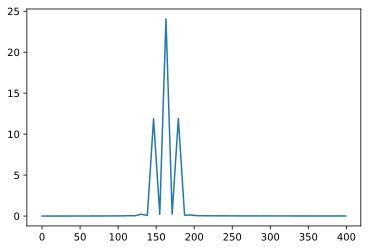

In [6]:
# app.py

import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack

# Number of sample points
N = 100
# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N)
y = analysis_gilbert_real_am['OUT_A'] - analysis_gilbert_real_am['OUT_B']
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

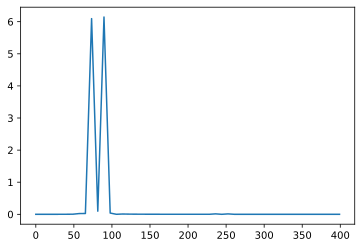

In [7]:
# Number of sample points
N = 100
# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N)
y = analysis_gilbert_am['OUT_A'] - analysis_gilbert_am['OUT_B']
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


In [8]:
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath(
    'schema', 'schema.cir')
parser = SpiceParser(path=str(kicad_netlist_path))
schema = parser.build_circuit(ground='GND')
schema.include(spice_library['BC547B'])
schema.include(spice_library['OPA2134d'])

class VoltageDivider1(SubCircuitFactory):
    __name__ = 'voltage_divider_1'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

#for subcircuit in (VoltageDivider1(R=100@u_kOhm,w=0.001)):
#    schema.subcircuit(subcircuit)
schema.subcircuit(VoltageDivider1(R=100@u_kOhm,w=1))

print(str(schema))


.title KiCad schematic
.include /home/etienne/Documents/elektrophon/lib/spice/transistor/BC547.mod
.include /home/etienne/Documents/elektrophon/lib/spice/opamp/OPA2134-dual.lib
.subckt voltage_divider_1 n1 n2 n3
R1 n1 n2 100.0kOhm
R2 n2 n3 0.0kOhm
.ends voltage_divider_1
V1 +15V 0 +15
V2 -15V 0 -15
Q1 OUT_A Net-_C5-Pad1_ Net-_Q1-Pad3_ BC547B
Q3 OUT_B Net-_Q3-Pad2_ Net-_Q1-Pad3_ BC547B
Q4 OUT_A Net-_Q3-Pad2_ Net-_Q4-Pad3_ BC547B
Q6 OUT_B Net-_C5-Pad1_ Net-_Q4-Pad3_ BC547B
R9 +15V OUT_A 270
R13 +15V OUT_B 270
Q2 Net-_Q1-Pad3_ Net-_C6-Pad1_ Net-_Q2-Pad3_ BC547B
Q5 Net-_Q4-Pad3_ Net-_Q5-Pad2_ Net-_Q2-Pad3_ BC547B
R16 +15V Net-_C7-Pad2_ 4.7k
R17 Net-_C7-Pad2_ Net-_C9-Pad1_ 3.3k
R18 Net-_C9-Pad1_ 0 2.2k
C8 Net-_C7-Pad2_ 0 0.1u
C9 Net-_C9-Pad1_ 0 0.1u
V3 +5V 0 dc 5
R15 Net-_C7-Pad2_ Net-_C5-Pad1_ 2.2k
R11 Net-_C7-Pad2_ Net-_Q3-Pad2_ 2.2k
R14 Net-_C9-Pad1_ Net-_Q5-Pad2_ 2.2k
R10 Net-_C9-Pad1_ Net-_C6-Pad1_ 2.2k
C7 0 Net-_C7-Pad2_ 0.1u
C5 Net-_C5-Pad1_ in 0.1u
C6 Net-_C6-Pad1_ cv 0.1u
R12 Net-_

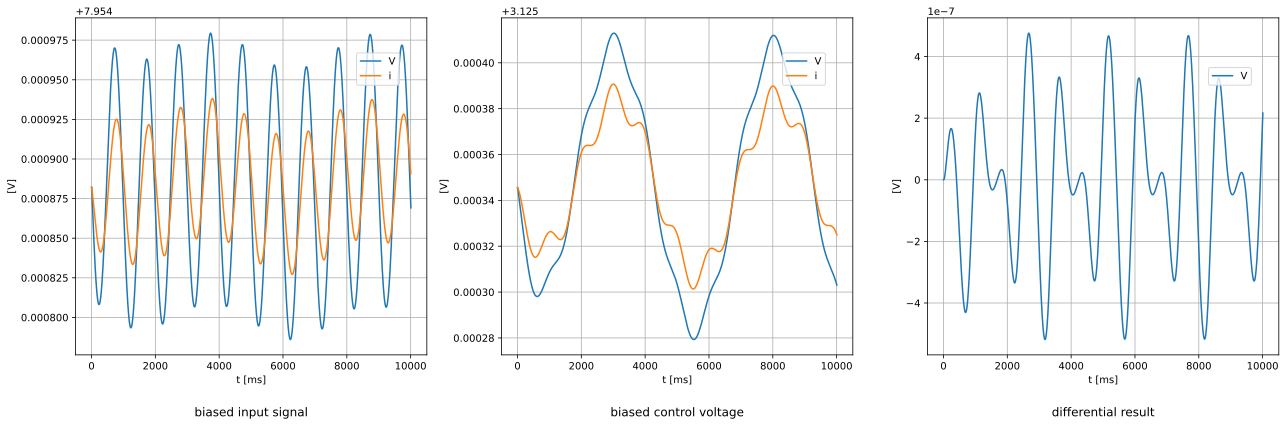

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#schema.V('3', 'AUDIO_IN', gilbert_cell_envelope.gnd, 'DC 0V AC 0V SIN(4 10m 1k)')
#gilbert_cell_envelope.V('4', 'CV', gilbert_cell_envelope.gnd, 'DC 0V AC 0V PULSE(2 1990m 1m 1u 10m 1u)')

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis_schema = simulator.transient(step_time=1@u_us, end_time=10@u_ms)

print(analysis_schema)

ax0.plot(analysis_schema['Net-_C5-Pad1_'])  # scaled input voltage
ax0.plot(analysis_schema['Net-_Q3-Pad2_'])  # scaled input voltage
ax0.legend('Vin  [V]', loc=(.8, .8))
ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('biased input signal', y=-0.2)

ax1.plot(analysis_schema['Net-_C6-Pad1_'])  # scaled input voltage
ax1.plot(analysis_schema['Net-_Q5-Pad2_'])  # scaled input voltage
ax1.legend('Vin  [V]', loc=(.8, .8))
ax1.grid()
ax1.set_xlabel('t [ms]')
ax1.set_ylabel('[V]')
ax1.set_title('biased control voltage', y=-0.2)

#ax0.plot(analysis_schema['Net-_C7-Pad1_'])  # scaled input voltage
ax2.plot(analysis_schema['OUT_B']-analysis_schema['OUT_A'])  # scaled input voltage
ax2.legend('Vin  [V]', loc=(.8, .8))
ax2.grid()
ax2.set_xlabel('t [ms]')
ax2.set_ylabel('[V]')
ax2.set_title('differential result', y=-0.2)

plt.tight_layout()
plt.show()

In [11]:
simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis_op = simulator.operating_point()

# Operating point analysis
for node in analysis_op.nodes.values():
    print('Node {}: {:5.2f} V'.format(str(node), float(node)))

print( 'Audio input signal is %f Volts.' % (float(analysis_op['in'])))
print( 'CV input signal is %f Volts.' % (float(analysis_op['cv'])))



Node xu2.xu1b.8: -0.05 V
Node xu2.xu1b.9:  0.00 V
Node xu2.xu1b.92: -40.00 V
Node xu2.xu1b.91: 40.00 V
Node xu2.xu1b.90:  0.00 V
Node xu2.xu1b.54: -14.10 V
Node xu2.xu1b.53: 13.80 V
Node net-_r20-pad1_: -0.05 V
Node xu2.xu1b.99:  0.00 V
Node xu2.xu1b.10: -0.77 V
Node xu2.xu1b.7: -0.05 V
Node xu2.xu1b.6:  0.00 V
Node xu2.xu1b.12: -14.80 V
Node xu2.xu1b.11: -14.80 V
Node xu2.xu1a.8: -0.05 V
Node xu2.xu1a.9:  0.00 V
Node xu2.xu1a.92: -40.00 V
Node xu2.xu1a.91: 40.00 V
Node xu2.xu1a.90:  0.00 V
Node xu2.xu1a.54: -14.10 V
Node xu2.xu1a.53: 13.80 V
Node net-_r19-pad1_: -0.05 V
Node xu2.xu1a.99:  0.00 V
Node xu2.xu1a.10: -0.77 V
Node xu2.xu1a.7: -0.05 V
Node xu2.xu1a.6:  0.00 V
Node xu2.xu1a.12: -14.80 V
Node xu2.xu1a.11: -14.80 V
Node net-_r6-pad1_: -0.05 V
Node net-_r2-pad2_:  5.00 V
Node net-_j2-padt_:  5.00 V
Node net-_j1-padt_:  5.00 V
Node net-_r1-pad2_:  5.00 V
Node net-_r5-pad1_: -0.05 V
Node xu1.xu1b.8: -5.00 V
Node xu1.xu1b.9:  0.00 V
Node net-_r2-pad1_:  0.00 V
Node xu1.xu1b.92: -4

## *references*

- [VCA Techniques Investigated][1] Rod Elliott (ESP)
- [VCA-1][2] Thomas Henry CA3080 vca
- [VCA-3][3] René Schmitz differential pair vca
- [#223][]: Basics of the Gilbert Cell | Analog Multiplier | Mixer | Modulator

[1]: https://sound-au.com/articles/vca-techniques.html
[2]: https://www.birthofasynth.com/Thomas_Henry/Pages/VCA-1.html
[3]: https://www.schmitzbits.de/vca3.png
[4]: https://www.youtube.com/watch?v=7nmmb0pqTU0&t=2s
[5]: 


[9]: http://www.ecircuitcenter.com/Circuits/BJT_Diffamp1/BJT_Diffamp1.htm
